[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TomGeorge1234/DeepLearningTutorial/blob/main/deeplearning.ipynb)

# **Deep learning tutorial** 
## Tom M. George, University College London

In this tutorial we will get hands on building deep neural networks and training them via backproagation. Initially the goal is to **avoid autograd packages**, such as `pytorch` or `jax` at all costs. Coding a deep neural network by hand this will help us gain an understanding of the mathematics going on behind the scenes. At the end we will use `pytorch` to build a much deeper network and see how it performs. Here's the plan: 

0. **Set-up**: Generate some data for a neuroscience-inspired task our networks will try to learn
1. **Linear regression**: A simple model with an analytic solution. We'll use this as a comparison later on. 
2. **Deep Neural Networks (by hand)**: Derive the learning rules for a deep neural network with two hidden layers and code this by hand.
3. **Deep neural networks (by `pytorch`)**: Using an autograd package to show how these models can be scaled efficiently.


# 0. Task set-up: predicting position from neural firing rates
Since this is a summer school on computational neuroscience we will design a neuroscience inspired task to train our networks on. The task we will train our network on will be **to predict position of an agent from the firing of a bunch of place cells**.  To generate place cell data we will use the `RatInABox` which was probably introduced earlier in the summer school.

The dataset (in machine learning notation $\mathcal{D} = \{(x_i,y_i)\}_{i=1}^{N}$)  consists of tuples of inputs $x_i$ and outputs ("targets") $y_i$...
* $x_i = [f_1(t_i), f_2(t_i), ..., f_{N_{\textrm{cells}}}(t_i)]^{\mathsf{T}} \in \mathbb{R}^{N_{\textrm{cells}}}$ is the vector of firing rates of all cells at the time corresponding to the $i^{\textrm{th}}$ training datapoint 
* $y_i = [\mathsf{x},\mathsf{y}]^{\mathsf{T}} \in \mathbb{R}^{2}$ is the position $[\mathsf{x},\mathsf{y}]^{\mathsf{T}}$ vector of the agent at the time corresponding to the $i^{\textrm{th}}$ training datapoint. 

<center><img src="./figs/task_setup.png" width=1000></center>

We will split this dataset (total 20 minutes) into training and testing portions: 
* $\mathcal{D}_{\textrm{train}} = \{(x_i,y_i)\}_{i=1}^{N_{\textrm{train}}}$ is the first 18 minutes of exploration data. 
* $\mathcal{D}_{\textrm{test}} = \{(x_i,y_i)\}_{i=N_{\textrm{train}}+1}^{N}$ is the final 2 minutes of exploration data. 

Final, we may occasionally find it useful to stack these lists of datapoints into "data matrices". These will always be represented with Capitalised variables where the first index iterates over the datapoint, for example: $X \in \mathbb{R}^{N \times N_{\textrm{cells}}}$ where $X_{ij} = [x_i]_{j}$, likewise, $Y_{\textrm{train}} \in \mathbb{R}^{N_{\textrm{train}} \times 2}, ... etc.$

<center><img src="./figs/vectorisation.png" width=400></center>

In [18]:
# INSTALL AND IMPORT SOME PACKAGES
!pip install -U ratinabox==1.4.2 # for data generation only
!pip install tqdm # for progress bars
!pip install torch # pytorch, for deep learning section 3 

import ratinabox # for data generation only
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from ratinabox.Neurons import PlaceCells, GridCells
ratinabox.stylize_plots(); ratinabox.autosave_plots=False

import matplotlib.pyplot as plt # for plotting stuff 
import numpy as np # for math stuff
from tqdm.auto import tqdm # for progress bars

## 0.1 Generate data using `ratinabox`

In [32]:
n_cells = 10 #number of cells 
T = 20 # minutes of data 

# make the environment, put an agent in it, and give the agent some place cells 
Env = Environment(
    # params={'holes':[[[0.1,0.1],[0.3,0.1],[0.3,0.3],[0.1,0.3]]]}  # make a hole in the environment 
) # defaults to a 1 x 1 meter square environment
Env.add_wall([[0.5,0.0],[0.5,0.5]])
Ag = Agent(Env)
PCs = PlaceCells(Ag,params={'n':n_cells})

# make the data
train_frac = 0.9
while Ag.t < T*60:  
    Ag.update(dt=0.1)
    PCs.update()

## 0.2 Plot the data
Lets plot the data to see what it looks like. We'll display 
* The place fields we're using to construct the data
* The data: iputs and outputs split into training (blue) and testing (green) fractions


Text(0.5, 1.0, 'Outputs, Y')

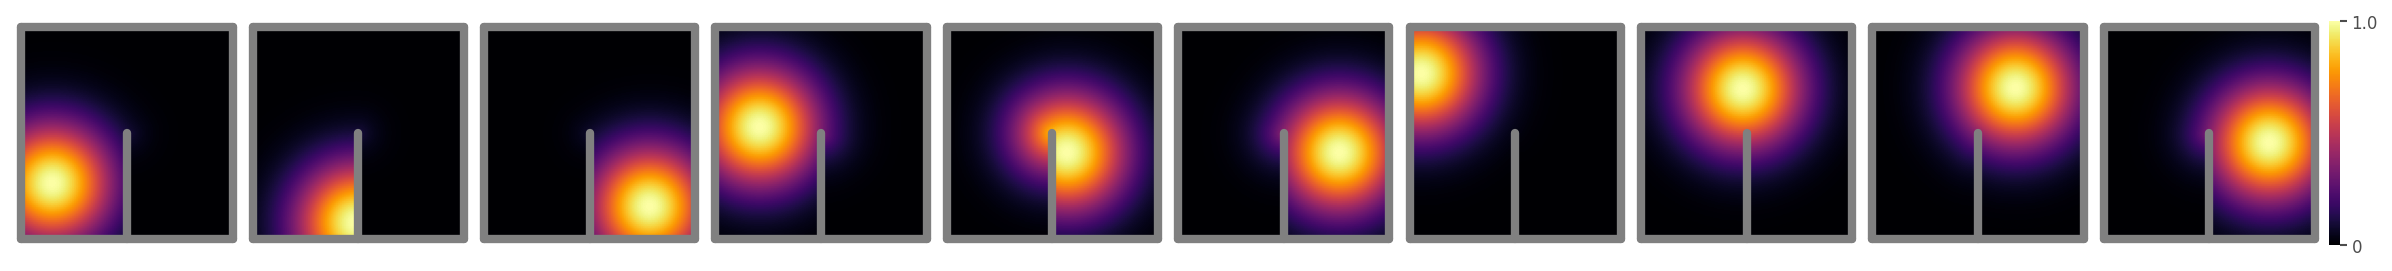

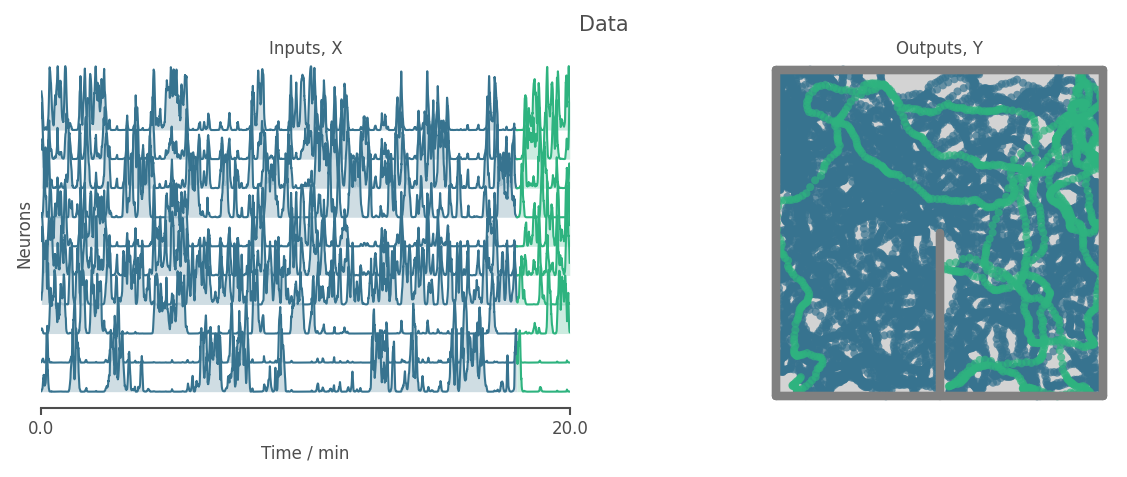

In [33]:
PCs.plot_rate_map() #show the place cells

# visualise the training a testing data
fig, ax = plt.subplots(1,2,figsize=(10,3))
PCs.plot_rate_timeseries(ax=ax[0], t_end=train_frac*T*60, color='C1')
PCs.plot_rate_timeseries(ax=ax[0],t_start=train_frac*T*60,color='C2')
Ag.plot_trajectory(fig=fig, ax=ax[1], t_end=train_frac*T*60, color='C1', plot_agent=False)
Ag.plot_trajectory(fig=fig, ax=ax[1], t_start=train_frac*T*60, color='C2', plot_agent=False)
fig.suptitle("Data")
ax[0].set_title("Inputs, X")
ax[1].set_title("Outputs, Y")


## 0.2 Extract the data into `numpy` arrays 
Finally lets extract the data into nice, workable `numpy` matrices. 

In [34]:
id = np.where(np.array(Ag.history['t']) > T*train_frac*60)[0][0] # datapoint id where training ends and testing starts 

X_train = np.array(PCs.history['firingrate'][:id])
Y_train = np.array(Ag.history['pos'][:id])
X_test = np.array(PCs.history['firingrate'][id:])
Y_test = np.array(Ag.history['pos'][id:])

print(f"X_train.shape = {X_train.shape} \nY_train.shape = {Y_train.shape}, \nX_test.shape = {X_test.shape}, \nY_test.shape = {Y_test.shape}")

X_train.shape = (10799, 10) 
Y_train.shape = (10799, 2), 
X_test.shape = (1201, 10), 
Y_test.shape = (1201, 2)


## 0.3 Abstract model class
Before we start we'll make an abstract model class that we'll use to test, train and visualise future models that we'll build

In [35]:
#Abstract class (we'll use this a few times for different types of Model): 
# You can ignore most of this boiler plate code, it's just to make sure that all models have the same interface and plotting functions
class Model:
    def __init__(self, 
                 X_train=X_train, 
                 Y_train=Y_train, 
                 X_test=X_test, 
                 Y_test=Y_test,
                 ):
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.use_bias = True
        self.n_train = self.X_train.shape[0]
        self.n_in = self.X_train.shape[1]
        self.n_out = self.Y_train.shape[1]

        #epoch counter and save history
        self.epoch = 0
        self.history = {'epoch':[],'loss':[], 'test_loss':[], 'error':[], 'test_error':[]}
    
    def forward(self, X):
        """Each model must have a forward function which takes some array of inputs X and returns the predicted outputs Y_pred"""
        raise NotImplementedError

    def fit(self):
        """Each model must have a fit function which ,in one way or another, uses the raining data to optimise the parameters (weights) of the model."""
        raise NotImplementedError

    def plot_testing_performance(self, fig=None, ax=None, title=None):
        """Plot the predicted and true trajectory of the agent and the average error,
        if traindata is True, use the training data instead of the testing data"""
        X = self.X_test
        Y = self.Y_test
        Y_pred = self.forward(X)
        fig, ax = Ag.plot_trajectory(fig=fig,ax=ax,t_start=T*train_frac*60, color='C2', plot_agent=False)
        ax.scatter(Y_pred[:,0], Y_pred[:,1], color='r', alpha=0.7, s=1, zorder=2)
        lin_error_before = error(Y_pred,Y)
        if title is None: title = self.name 
        title += f"\n(av. error = {100*lin_error_before:.2f} cm)"
        ax.set_title(title)
        return fig, ax 

    def plot_training_error(self, comparison=None):
        """Plot the training and testing error as a function of epoch, if comparison is not None, plot the error of those models onto for comparison"""
        fig, ax = plt.subplots(figsize=(3,2))
        epochs = self.history['epoch']
        train_error = self.history['error']
        test_error = self.history['test_error']
        ax.plot(epochs, train_error, label='train',c='C1',linewidth=2)
        ax.plot(epochs, test_error, label='test',c='C2',linewidth=2)
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Error / cm")
        ax.set_yscale('log')
        if comparison is not None:
            if not isinstance(comparison, list):
                comparison = [comparison]
            for (i,comparison_) in enumerate(comparison):
                Y_comp = comparison_.forward(self.X_test)
                error_comp = error(Y_comp, Y_test)
                ax.axhline(error_comp, c='C'+str(3+i),linestyle="--",label=comparison_.name+" comparison")
        ax.legend()
        return fig, ax 

    def add_dummy_row(self,X):
        """X is shape (T x N), add a row of ones to the first column making it (T x N+1) if and only is self.use_bias is True"""
        if self.use_bias == True: 
            return np.hstack((np.ones((X.shape[0],1)), X))
        else:
            return X

def loss(Y_pred, Y_true):
    """Mean squared error"""
    return np.mean((Y_pred-Y_true)**2)

def error(Y_pred, Y_true):
    """How far, in meters, the predictions are away from the true values (on average)"""
    return np.mean(np.linalg.norm(Y_pred-Y_true, axis=1))

# 1. Linear regression

First, as a benchmark, lets study the most trivial network possible: a linear network with no hidden layers. A set of weights $w \in \mathbb{R}^{N_{\textrm{cells}} \times 2}$ maps the inputs (firing rates) to the outputs (position). The hat on $\hat{y}$ represents the fact this is our "estimate" of the output, not necessarily the correct output:

$$\hat{y}_{i} = x_{i}  w $$

We can also improve this model by including a bias $\hat{y}_i = x_i\cdot w + b$. The most elegant (and simple) way to do this is to append a fixed "dummy row" to all inputs $x_{i,0} = 1$ then the first weight $w_0 = b$ acts as a bias term. By default we will always use biases where approriate using this dummy-method. Note the above equation encompases the vector-ness of $x_i$: since $x_i \in \mathbb{R}^{N_{\textrm{cells}}}$ and $w \in \mathbb{R}^{N_{\textrm{cells}} \times 2}$ then $\hat{y}_{i} = x_{i}  w$ implies summation over the inner-most index giving an output $\hat{y}_{i} \in \mathbb{R}^{2}$
<center><img src="./figs/linear_model.png" width=300></center>

In [36]:
#An instance of this class for our current model of interest: Linear regression
class LinearModel(Model):
    """A linear regression model"""
    def __init__(self, 
                 **kwargs, #passed to parent class 
                 ):
        super().__init__(**kwargs)
        self.name="Linear Model"
        n_in = self.X_train.shape[1]
        n_out = self.Y_train.shape[1]
        self.w = np.random.normal(scale=0.1,size=(n_in+self.use_bias, n_out))
    
    def forward(self, X):
        X = self.add_dummy_row(X)
        Y = np.dot(X, self.w)
        return Y

## 1.1 Optimising linear models (_without_ gradient descent)

We want to find the weights which minimise some measure of "loss" between out estimate $\hat{y}$ and the true value of the agents position $y$. For this we will use the $L_2$ loss:

$$\mathcal{L}(\mathcal{D}_{\textrm{train}};w) = \sum_{i = 1}^{N_{\textrm{train}}}||\hat{y}_i - y_i||^{2}$$

To minimise this we could use gradient descent (which we will do in the next section) but, in fact, this model is simle enough we can solve immediately for the minimum by finding where its derivative with respect to the weights equals to zero. Note this analytic approach won't be possible later on with deeper non-linear models.

$$\frac{\partial \mathcal{L}}{\partial w} \bigg \vert_{w=w^*} = 0$$

<center><img src="./figs/loss_minima.png" alt="Linear model" width=250 /></center>


**Optional excersize 1.1:** show the solution to the above equation is (solution is at the end of the repo): 

$$ w^* = (X_{\textrm{train}}^{\mathsf{T}}X_{\textrm{train}})^{-1}(X_{\textrm{train}}^{\mathsf{T}}Y_{\textrm{train}}) $$

We'll add a method called `fit` to our linear model which sets the weights according to the above equation


In [7]:
def fit(Model): 
    """Fit the linear model to the training data"""
    X_train = Model.add_dummy_row(Model.X_train) 
    Model.w = np.dot(np.linalg.inv(np.dot(X_train.T, X_train)), np.dot(X_train.T, Model.Y_train)) # w = (X^T X)^-1 X^T Y
    
LinearModel.fit = fit # assign this method to the linear model class

## 1.2 Linear model performance
Now lets check out the performance of our linear model

(<Figure size 900x450 with 2 Axes>,
 <Axes: title={'center': 'Linear model after fitting\n(av. error = 11.48 cm)'}>)

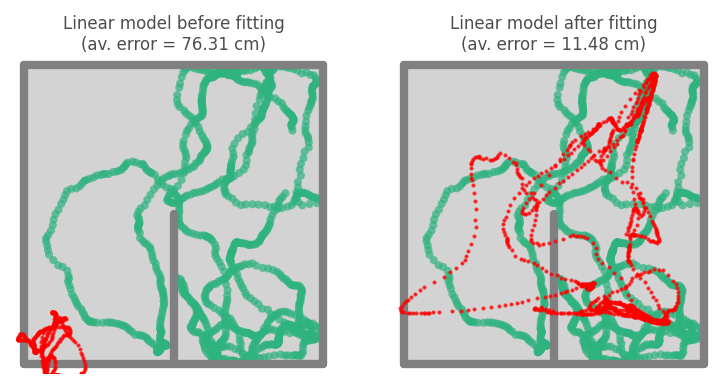

In [8]:
LinMod = LinearModel()

fig, ax = plt.subplots(1,2,figsize=(6,3))
#before fitting (random weights)
LinMod.plot_testing_performance(fig=fig,ax=ax[0],title="Linear model before fitting")

#after fitting (using bias)
LinMod.fit()
LinMod.plot_testing_performance(fig=fig,ax=ax[1],title="Linear model after fitting")

# 2. Deep neural networks (trained _without_ autograd packages)

Here we're going to build a small neural network with two hidden layers and train it with backpropagation to solve the same task: prediction position from neural firing rates. Each layer will be non-linear function of the layer before it. It will help to differentiate between the activations of the layers _pre-_ and _post-activation_, which we'll call $n_i$ and $h_i$ respectively: 

$$
\begin{align}
n^{(1)}_i = x_{i} w^{(1)} \hspace{1cm}&\hspace{1cm} h^{(1)}_i = \sigma (n^{(1)}_i) \\
n^{(2)}_i = h^{(1)}_{i} w^{(2)} \hspace{1cm}&\hspace{1cm} h^{(2)}_i = \sigma (n^{(2)}_i) \\
n^{(3)}_i = h^{(2)}_{i} w^{(3)} \hspace{1cm}&\hspace{1cm} \hat{y}_i = \sigma (n^{(3)}_i) \\
\end{align}
$$
 
Once again we'll pull the same trick of appending a dummy row to all the inputs (and subsequent hidden layers) to allow for the inclusion of a bias (i.e. the equations above should really read $h^{(n)}_i = \sigma (h^{(n-1)}_i  w^{(n)} + b^{(n)})$ but we've absorbed the biases into the weights).

<center><img src="./figs/dnn.png" width=600 /></center>


In [37]:
class DeepNeuralNetwork(Model):
    """A deep neural network containing two hidden layers"""
    def __init__(self,
                 activation=None, #pass a function here
                 n_hidden=200,
                 eta=0.01,
                 l2=0.0001,
                 **kwargs):
        
        super().__init__(**kwargs)

        self.name = "Hand-coded DNN"
        self.activation = activation # a function 
        self.eta = eta
        self.l2 = l2

        #initialize weights
        scale = 3
        self.w1 = np.random.normal(scale=scale/np.sqrt(n_hidden), size=(self.n_in+self.use_bias, n_hidden))
        self.w2 = np.random.normal(scale=scale/np.sqrt(n_hidden), size=(n_hidden+self.use_bias, n_hidden))
        self.w3 = np.random.normal(scale=scale/np.sqrt(n_hidden), size=(n_hidden+self.use_bias, self.n_out))
    
    def forward(self, X, save=False):

        #input batch 
        self.X = X

        #input to hidden layer 1
        self.X_ = self.add_dummy_row(self.X) #add effective dummy row (bias)
        self.N1 = np.dot(self.X_, self.w1)
        self.H1 = self.activation(self.N1)

        #hidden layer 1 to hidden layer 2 
        self.H1_ = self.add_dummy_row(self.H1) #add effective dummy row (bias) 
        self.N2 = np.dot(self.H1_, self.w2)
        self.H2 = self.activation(self.N2) #no activation function on final layer 
        
        #hidden layer 2 to output layer
        self.H2_ = self.add_dummy_row(self.H2) #add effective dummy row (bias)
        self.N3 = np.dot(self.H2_, self.w3)
        self.Y = self.activation(self.N3)

        return self.Y

## 2.1 ReLU non-linearity sits between each layer
For the activation function we'll use the rectified linear unit. This is one of the most simple and commonly used non-linearities. 

Adding a non-linearity between each layer is crucial to explaining the power of deep learning model. Non-linear function are model complex and expresive than linear functions meaning they can (with the right parameters) model more complex functions which linear models aren't able to. 

<center><img src="./figs/activations.png" width=800 /></center>


In [38]:
def relu(X,deriv=False):
    "Rectified linear unit. If deriv=True, returns the derivative of the ReLU function (i.e. a step function)."
    if deriv == False: 
        return np.maximum(0,X)
    else:
        return 1.0*(X>0)

# =============================================================================
# Optional other activation functions
# =============================================================================

def sigmoid(X,deriv=False):
    "Sigmoid function. If deriv=True, returns the derivative of the sigmoid function."
    if deriv == False: 
        return 1.5/(1+np.exp(-X))
    else:
        return 1.5*sigmoid(X)*(1-sigmoid(X))

def tanh(X,deriv=False):
    "Hyperbolic tangent function. If deriv=True, returns the derivative of the tanh function."
    if deriv == False: 
        return 1.5*np.tanh(X)
    else:
        return 1.5*(1-np.tanh(X)**2)

## 2.2 Optimising a model with gradient descent 
The loss, as before, is the $L_2$ loss between the predicted output and the true output. It is a function of the training data and both weight vectors:

$$
\begin{align}
\mathcal{L}(\mathcal{D}_{\textrm{train}};w^{(1)},w^{(2)},w^{(3)}) &= \frac{1}{N_{\textrm{train}}} \sum_{i = 1}^{N_{\textrm{train}}}||\hat{y}_i - y_i||^{2} \\ 
&:= \frac{1}{N_{\textrm{train}}}\sum_{i=1}^{N_{\textrm{train}}} \mathcal{L}_{i}
\end{align}
$$

The problem is that now the model is too complex for us to find the minimum of this loss function analytically (like we did with linear regression). Enter, gradient descent.

If we know the derivative of the loss function with respect to one of the weights we can **adjust that weight in such a way that the loss must decrease**. Iterating such a procedure causes the loss to continually reduce until a minimum is found. This is called "gradient descent". 

The change in the loss function $\delta \mathcal{L}$ for a given small change in the weights $\delta{w}$ is:

$$ \delta \mathcal{L} = \frac{\partial \mathcal{L}}{\partial{w}} \delta{w}$$ 

If the weight change is aligned with the loss gradient this __must be negative__

$$ \textrm{if} \hspace{1cm} \delta w := -\eta \frac{\partial \mathcal{L}}{\partial{w}} \hspace{1cm} \textrm{then} \hspace{1cm} \delta \mathcal{L} = -\eta \bigg(\frac{\partial \mathcal{L}}{\partial{w}}\bigg)^2 \hspace{1cm} \textrm{which guarantees that} \hspace{1cm}\delta \mathcal{L} < 0$$

in other words...such a weight change means we _must_ decrease the loss and therefore (in theory) _improve the model_. In practise this usually works very well, a discovery which is arguably the biggest revolution in machine learning in the 20th century.

<center><img src="./figs/gradient_descent.png" width=400 /></center>


## 2.3 Calculating the gradients: "backpropagation"

So how do we calculate the gradient? And how do we do this "efficiently"? Since we have all the equations of the model we can just use some simple calculus (the chain rule) to calculate out the gradient by hand. Don't worry if you're not familiar with some of the notation coming up.., we'll step through it bit by bit. 

* Let's start with the weights in the final layer, $w^{(3)}$:

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial w^{(3)}} &= \frac{1}{N_{\textrm{train}}} \sum_i \frac{\partial \mathcal{L}_i}{\partial w^{(3)}}\\ 
&= \frac{1}{N_{\textrm{train}}} \sum_i \frac{\partial \mathcal{L}_i}{\partial \hat{y}_i} \frac{\partial \hat{y}_i}{\partial n^{(3)}_i} \frac{\partial n^{(3)}_i}{\partial w^{(3)}}
\end{align}
$$ 

   All three terms here are relatively easy to work out:

$$\frac{\partial \mathcal{L}_i}{\partial \hat{y}_i} = 2(\hat{y}_i - y_i) \hspace{1cm} \textrm{and} \hspace{1cm} \frac{\partial \hat{y}_i}{\partial n^{(3)}_i} = \sigma^{\prime}(n^{(3)}_i) \hspace{1cm} \textrm{and} \hspace{1cm} \frac{\partial n^{(3)}_{i}}{\partial w^{(3)}} = h^{(2)}_i$$

Putting this together gives: 

$$\frac{\partial \mathcal{L}}{\partial w^{(3)}} = \frac{1}{N_{\textrm{train}}} \sum_i 2(\hat{y}_i - y_i) \sigma^{\prime}(n^{(3)}_i)  h^{(2)}_i $$

* Now lets try calculate the gradient of the weights on the intermediate layer, $w^{(2)}$: 

test 
$$ \color{red}{ abc} \color{d}{} $$

$$
\begin{align}
\color{red} abc \color{d}
\end{align}
$$ 

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial w^{(2)}} &= \frac{1}{N_{\textrm{train}}} \sum_i \frac{\partial \mathcal{L}_i}{\partial w^{(2)}} \\ 
&= \frac{1}{N_{\textrm{train}}} \sum_i \color{green}{\underbrace{\frac{\partial \mathcal{L}_i}{\partial \hat{y}_i} \frac{\partial \hat{y}_i}{\partial n^{(3)}_i}}_{\textrm{already calculated}}} \color{d}{} \underbrace{\frac{\partial n^{(3)}_i}{\partial h^{(2)}_i} \frac{\partial h^{(2)}_i}{\partial n^{(2)}_i} \frac{\partial n^{(2)}_i}{\partial w^{(2)}}}_{\textrm{need to calculate}} \\
&= \frac{1}{N_{\textrm{train}}} \sum_i \color{green}{2(\hat{y}_i - y_i) \sigma^{\prime}(n^{(3)}_i)} \color{orange}{w^{(3)} \sigma^{\prime}(n^{(2)}_i)} \color{d} h^{(1)}_i
\end{align}
$$

Notice the term coloured in green appeared in the first calculation for $\frac{\partial \mathcal{L}}{\partial w^{(2)}}$. We can reuse this so we don't have to calculate it again. This efficiency saving may seem petty now but will be important for very deep networks later on. 

* Finally, lets calculate the derivative with respect to the weigths in the first layer, $w^{(1)}$. This time I'll leave it as an **optional excersize** for you to derive it but hopeful you can see some of the patterns emerging. We can pretty much just "look" at the above equations and guess what the next in the pattern will be:

$$ \frac{\partial \mathcal{L}}{\partial w^{(1)}} = \frac{1}{N_{\textrm{train}}} \sum_i \color{green}{2(\hat{y}_i - y_i) \sigma^{\prime}(n^{(3)}_i)} \color{orange}{w^{(3)} \sigma^{\prime}(n^{(2)}_i)}  \color{pink}{w^{(2)} \sigma^{\prime}(n^{(1)}_i)} \color{d} x_i $$

### 2.3.1 Some housekeeping: Vectorising our learning rule updates

So we don't have to do an arduous `for`-loop over all the data point (these are really slow in python) we can vectorise these update equations. The goal is to write them not as sums over all the data point in $\mathcal{D}_{\textrm{train}}$ but as matrix equations on the data matrices $X_{\textrm{train}}$ and $Y_{\textrm{train}}$. This means we can perform the sum over all the datapoints in a simple dot-product. This step is really _not critical_ but it makes our equations look nicer and our code run faster. **Optional excersize (solution at the end)**: convince yourself that the following are true: 

$$ 
\begin{align}
\frac{\partial \mathcal{L}}{\partial w^{(3)}} = \frac{H^{(2)^{\mathsf{T}}}}{N_{\textrm{train}}}  \cdot  &\color{green}{\big( 2 (\hat{Y}-Y_{\textrm{train}}) \circ \sigma^{\prime}(N^{(3)}) \big)} \color{d} \\
\frac{\partial \mathcal{L}}{\partial w^{(2)}} = \frac{H^{(1)^{\mathsf{T}}}}{N_{\textrm{train}}} \cdot \color{orange}{\big( \big(}  &\color{green}{\big( 2 (\hat{Y}-Y_{\textrm{train}}) \circ \sigma^{\prime}(N^{(3)}) \big) }\cdot \color{orange}{w^{(3)^{\mathsf{T}}} \big) \circ \sigma^{\prime}(N^{(2)})  \big)} \color{d}\\
\frac{\partial \mathcal{L}}{\partial w^{(1)}} = \frac{X_{\textrm{train}}^{\mathsf{T}}}{N_{\textrm{train}}} \cdot \color{pink}{\big( \big(} \color{orange}{\big( \big(}  &\color{green}{\big( 2 (\hat{Y}-Y_{\textrm{train}}) \circ \sigma^{\prime}(N^{(3)}) \big) }\cdot \color{orange}{w^{(3)^{\mathsf{T}}} \big) \circ \sigma^{\prime}(N^{(2)})  \big) } \cdot \color{pink}{w^{(2)^{\mathsf{T}}} \big) \circ \sigma^{\prime}(N^{(1)}) \big) }  \color{d}
\end{align}
$$

where $\circ$ is just the element-wise Hadamard product and capitalised terms represent terms vectorised (made into matrices) over the dataset index: $[N^{(2)}]_{i,:} = n^{(2)}_{i}$, etc. and $X^{\mathsf{T}}_{ij} = X_{ji}$ is the matrix transpose operator. Notice, again, the saving over the term in the green and orange terms we already calculated on the first two steps which we can reuse on the second and third. Although these formulae may look scary we can build them up slowly one by one...

### 2.3.2 Stochastic batched gradient descent 

I turns our it can be incredible computationally expensive to evaluate the gradient on the _whole_ training dataset, $X_{\textrm{train}}$. This is because there may be thousands, even millions of datapoints to average over all at once! 

Instead a common approach is to approximate the gradient on a small _batch_ of training data and iterate over many batches. A batch is just a random selection of a small number of the training datapoints. The gradient evaluated on a single batch isn't necessarily correct but it is, _on average_ correct. A batch might consist of a random selection of, say, 1% of the training data points.  

$$\mathcal{L}(\mathcal{D}_{\textrm{train}}) = \frac{1}{N_{\textrm{train}}}\sum_{i=1}^{N_{\textrm{train}}} \mathcal{L}_{i} \approx \frac{1}{N_{\textrm{batch}}}\sum_{j\in\mathcal{J}_{\textrm{batch}}}\mathcal{L}_{j} $$

## 2.4 Summary

1. We built a complex feed forwards model consisting of multiple stacked non-linear layers: $\hat{y}_{i} = \sigma(\sigma(\sigma(x_i \cdot w^{(1)})\cdot w^{(2)})\cdot w^{(3)})$
2. The loss depends deterministically on the weights between each layer: $\mathcal{L}(\mathcal{D}_{\textrm{train}};w^{(1)},w^{(2)},w^{(3)})$
3. We analytically calculated the _gradient_ of this loss with respect to each of the weights. The equations are written above. 
4. We can adjust each weight vector a small amount along the (negative) direction of this gradient. $\delta w = -\eta \frac{\partial \mathcal{L}}{\partial w}$. Doing so will decrease our loss and improve our model

Don't confuse gradient descent and backpropagation:
* **Gradient descent**: Applicable to many types of model (not just neural networks), the act of optimising parameters by taking small steps in weight space along the direction of the gradient in the loss function. Been around since the 1800s.
* **Backpropagation**:  Applicable to deep neural network models, the act of efficiently computing the gradient one layer at a time starting from the final layer and working back up through the network. Invented in the 1970s. 

## 2.5 Implementing stocastic gradient descent in code

Here we will write a `fit` function. This iterates over the training data in batchs. For each batch it:
1. Runs the `forward` function to calculate the predicted outputs. 
2. Uses these predicted values and the above equations to backpropagate through the network and calculate the gradients 
3. Update the weights 
4. Optional: Run the model on the test set and store the current error.


In [19]:
def fit_deep_network(Model,epochs=10,batch_frac=0.01):
    """Fit the deep neural network to the training data using batched stochastic gradient descent"""
    for _ in (pbar := tqdm(range(int(epochs / batch_frac)))):
        
        ##########################################################################
        # 1. GET A RANDOM BATCH OF TRAINING DATA 

        N_batch = int(batch_frac*Model.n_train)
        batch_ids = np.random.choice(Model.n_train,size=N_batch,replace=False)

        X_batch = Model.X_train[batch_ids]
        Y_batch = Model.forward(X_batch) #this also saves all the intermediate layer values too e.g. Model.H1, Model.H2, Model.N1, Model.N2, Model.N3
        Y_true = Model.Y_train[batch_ids]
        b = int(Model.use_bias) #int for whether we're using a bias term or not
    
        ##########################################################################
        # 2. COMPUTE GRADIENTS

        C3 = (Y_batch-Y_true) * Model.activation(Model.N3,deriv=True) # the term we'll reuse 
        dLdw3 = (2/N_batch) * (Model.H2_.T @ C3)
        
        C2 = (C3 @ Model.w3.T[:,b:]) * Model.activation(Model.N2,deriv=True)
        dLdw2 = (2/N_batch) * (Model.H1_.T @ C2)

        C1 = (C2 @ Model.w2.T[:,b:]) * Model.activation(Model.N1,deriv=True)
        dLdw1 = (2/N_batch) * (Model.X_.T @ C1)

        ##########################################################################
        # 3. USE GRADIENTS TO UPDATE WEIGHTS 

        Model.w3 -= Model.eta * dLdw3 + Model.l2 * Model.w3 # these last terms are L2 regularisation (you can ignore them for now)
        Model.w2 -= Model.eta * dLdw2 + Model.l2 * Model.w2 
        Model.w1 -= Model.eta * dLdw1 + Model.l2 * Model.w1 

        ##########################################################################
        # 4. STORE SOME HISTORY DATA 

        #compute distance error and save history
        Model.epoch += batch_frac
        Model.history['epoch'].append(Model.epoch)        
        Y_pred = Model.forward(Model.X_test)
        E_test = error(Y_pred, Model.Y_test)
        Model.history['error'].append(error(Y_batch,Y_true))
        Model.history['test_error'].append(E_test)
        pbar.set_description(f"Test error (cm): {100*E_test:.3f}")

DeepNeuralNetwork.fit = fit_deep_network


## 2.6 Construct and train the DNN 

**Note**: convergence of this network is not guaranteed (as you may well experience!). It is very likely that the optimisation procedure may get stuck in a local minima. This bug is a very real problem in machine learning and lots of work has been done to ameliorate this issue. 

If this happens: try cancelling, reinitialising the network, and starting again. 

In [26]:
DNN = DeepNeuralNetwork(activation=relu,eta=0.01)

In [27]:
DNN.fit(epochs=20)

Test error (cm): 4.942: 100%|██████████| 2000/2000 [00:58<00:00, 34.38it/s]


Now lets plot the training and testing error over time, and visualise the performance

(<Figure size 900x450 with 2 Axes>,
 <Axes: title={'center': 'Hand-coded DNN\n(av. error = 4.94 cm)'}>)

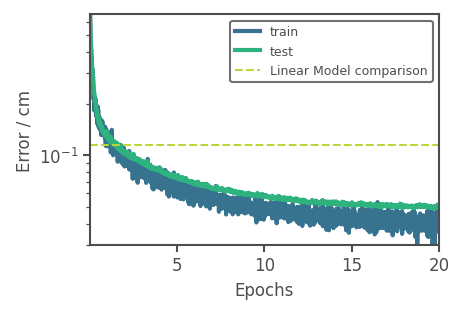

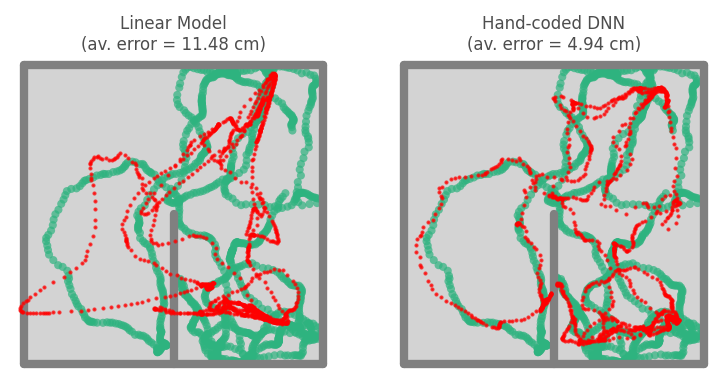

In [28]:
fig, ax = DNN.plot_training_error(comparison=LinMod)

fig, ax = plt.subplots(1,2,figsize=(6,3))
LinMod.plot_testing_performance(fig=fig,ax=ax[0])
DNN.plot_testing_performance(fig=fig,ax=ax[1])

## 2.7 (Optional) Backpropagation allows us to keep going, deeper and deeper 
The elegance of backprop is that we can keep going deep and deeper, extending the above process indefinitely. By stacking more and more layers together we make our model more and more complex (and therefore more powerful!). For each new layer calculating the gradient doesn't get much harder, we just need to calculate two extra terms each time. Imagine we have a network with $N$ hidden layers (where $h^{(0)}_i := x_i$ is the input and $h^{(N+1)}_i :=\hat{y}_i$ is the output.) The update step for the $n^{\textrm{th}}$ set of weights is, formulaically: 
$$
\delta w^{(n)} = - 2 \eta \frac{H^{(n-1)^{\mathsf{T}}}}{N_{\textrm{batch}}}\cdot(\hat{Y}-Y)\cdot C^{(n)}
$$
where $C^{(n)}$ is define recursively fron the layer after it: 
$$
C^{(n)} = \big( C^{(n+1)} \cdot w^{(n+1)^{\mathsf{T}}} \big) \circ \sigma^{\prime}(N^{(n)})
$$
and the top layer (where the recursion starts) is: 
$$C^{(N+1)} = \sigma^{\prime}(N^{(N+1)})$$

Now you can possible see why we call this "_backpropagation_". Starting from the final layer we "propagate" backwards calculating the gradient of each subsequent layer as we go. At each layer we map the error through the _transpose_ of the weight matrix to find the gradient of the layer below it. Contrast this to when we _evaluate_ a neural network in a forward sweep where we multiply by the weight matrix (not it's transpose). 

<center><img src="./figs/backprop.png" width=800 /></center>


NOTE: Although there is consensus that forward sweeps are plausible in biological networks of neurons there is _no such consensus_ that backward sweeps (i.e. backpropagation) are plausible since this would require neural networks to... 
* ...store two sets of weights: $w$ and $w^{\mathsf{T}}$
* ...and maintain activity during the forward sweep in order to establish the gradient later , once the backwards sweep has reached.
It is like neural networks use some coarse approximation to backpropagation or different learning rules altogether. 



# 3 Deeper neural networks trained with an autograd package, `pytorch`

## 3.1 Autograd package calcualte gradients automatically and efficiently
Autograd packages such as `pytorch` automate the process we wrote out by hand above. `pytorch` allows you to build arbitrarily complex networks. It maintains a memory trace of all the calculations performed and then when you want to perform gradient descent on the weights it intelligently works back through the trmemory trace to calculate the gradient with respect to all parameters. It does this efficiently and is optimized for GPU (we won't use this here) so can be used to train big networks on big dat sets incredibly fast. 

Now we will import `pytorch` and build a big neural network to solve the task. At it's core, know that its really just doing the same thing we hard coded up above (but with much less code to write!)...

## 3.2 Using `pytorch` to build an even deeper neural network
We'll make a network with 5 hidden layers, each containing 100 nodes. 

In [29]:
import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


class DeepNeuralNetworkTorch(Model,nn.Module):
    def __init__(self, hidden_size=100):
        Model.__init__(self)
        nn.Module.__init__(self)
        self.layer1 = nn.Linear(self.n_in, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(hidden_size, hidden_size)
        self.layer5 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, self.n_out)
        self.relu = nn.ReLU()
        self.name = "pytorch DNN"
        self.criterion = nn.MSELoss()
        self.optimizer = optim.AdamW(self.parameters(), lr=0.001)

    def forward(self, X, return_torch=False):
        """Forward pass, X can be numpy array or torch tensor. By default returns a (detached) numpy array but can return a torch tensor if return_torch=True.Do this if you intend to take gradients."""
        if isinstance(X, np.ndarray):
            X = torch.Tensor(X.astype(np.float32)) #pytorch uses its own kind of linear algebra objects (very similar to numpy)
        X = self.relu(self.layer1(X))
        X = self.relu(self.layer2(X))
        X = self.relu(self.layer3(X))
        X = self.relu(self.layer4(X))
        X = self.relu(self.layer5(X))
        X = self.output_layer(X)
        if return_torch == False:
            X = X.detach().numpy()
        return X

    def fit(self, epochs=100, batch_frac=0.1,verbose=True):
        if verbose == True: pbar = tqdm(range(int(epochs / batch_frac)))
        else: pbar = range(int(epochs / batch_frac))
        for _ in pbar:
            #get batch of data
            N_batch = int(batch_frac*self.n_train)
            batch_ids = np.random.choice(self.n_train,size=N_batch,replace=False)
            X_batch = self.X_train[batch_ids]
            Y_batch = self.forward(X_batch,return_torch=True)
            Y_true = torch.from_numpy(self.Y_train[batch_ids].astype(np.float32))

            #optimize the weights
            self.optimizer.zero_grad()
            loss = self.criterion(Y_batch, Y_true)
            loss.backward() #<--- this is where the magic happens!
            self.optimizer.step()

            #compute distance error and save history
            self.epoch += batch_frac
            self.history['epoch'].append(self.epoch)        
            Y_pred = self.forward(self.X_test)
            E_test = error(Y_pred, self.Y_test)
            self.history['error'].append(error(Y_batch.detach().numpy(),Y_true.detach().numpy()))
            self.history['test_error'].append(E_test)
            if verbose == True: pbar.set_description(f"Test error (cm): {100*E_test:.3f}")
        


Test error (cm): 0.683: 100%|██████████| 1000/1000 [00:05<00:00, 197.80it/s]


(<Figure size 1350x450 with 3 Axes>,
 <Axes: title={'center': 'pytorch DNN\n(av. error = 0.68 cm)'}>)

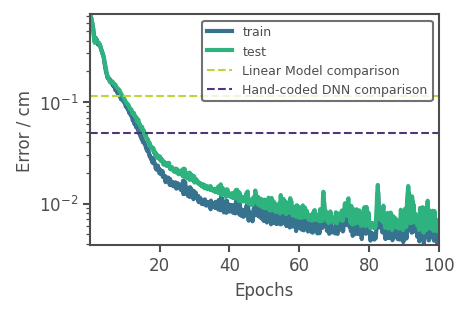

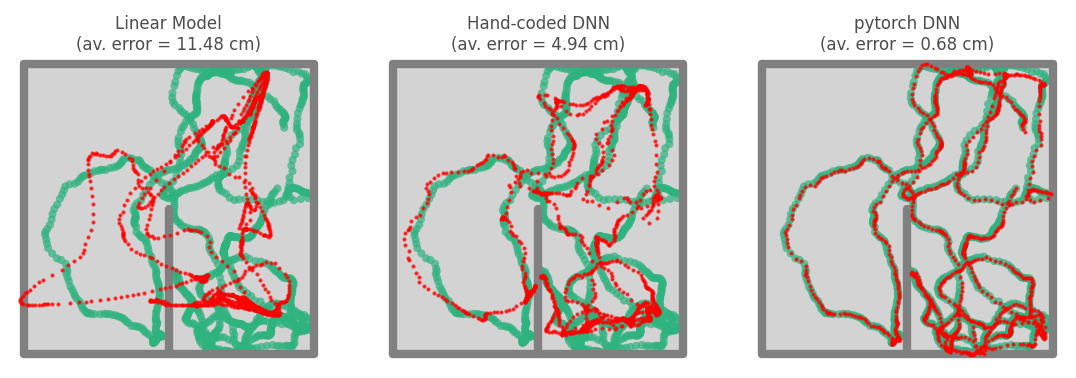

In [30]:
TDNN = DeepNeuralNetworkTorch()
TDNN.fit()

TDNN.plot_training_error(comparison=[LinMod,DNN])

fig, ax = plt.subplots(1,3,figsize=(9,3))
#before fitting (random weights)
LinMod.plot_testing_performance(fig=fig,ax=ax[0])
DNN.plot_testing_performance(fig=fig,ax=ax[1])
TDNN.plot_testing_performance(fig=fig,ax=ax[2])


Not only is it crazy fast (facebook software engineers are better at coding than I am it would appear), its _really_ accurate! This is down to the improved optimizer and the larger, deeper model. 

The optimizer we're using here is called "Adam" standing for "Adaptive moment estimation". It's a type of stochastic gradient descent but a bit more intelligent than the one we derived. It maintains a different learning rate for _each_ weight being learned and adapts these according to how the weight has been changing recently. For example weights have "momentum" (think of a ball rolling down a hill); if they're moving in one direction they tend to carry on moving in one direction. This allows them to overcome noise or local minima on the loss landscape. It's phenomenally successful as you can see by the above results. 

<center><img src="./figs/optimisers.png" width=800 /></center>


## 3.2.1 Visualise the learning over time

The following code produces an animation showing how the network learns over time

In [31]:
import matplotlib.animation

epochs = 50 
plot_every = 0.2

TDNN = DeepNeuralNetworkTorch()

fig, ax = TDNN.plot_testing_performance()

def animate(i,fig,ax):
    TDNN.fit(epochs=plot_every,verbose=False) #do one more epoch of fitting
    ax.clear()
    ax.text(0.0,-0.06,f"Epoch: {round(TDNN.epoch,2)}",size=7)
    fig, ax = TDNN.plot_testing_performance(fig=fig,ax=ax)
    plt.close()
    return

anim = matplotlib.animation.FuncAnimation(
    fig,
    animate,
    interval=50, #ms between frames
    frames=int(epochs/plot_every),
    blit=False,
    fargs=(fig, ax),)

from IPython.display import HTML
HTML(anim.to_html5_video())

# Solutions

## Optional excersize 1.1

Linear regression loss is: 
$$
\begin{align}
\mathcal{L}(\mathcal{D}_{\textrm{train}};w) = \sum_{i = 1}^{N_{\textrm{train}}}||\hat{y}_i - y_i||^{2} = \sum_{i = 1}^{N_{\textrm{train}}}(\hat{y}_{i} - y_i)  (\hat{y}_{i} - y_i)^{\mathsf{T}} \hspace{1cm} \textrm{where} \hspace{1cm} \hat{y}_{i} = x_{i} w 
\end{align}
$$

Note we're handling vectors, not scalars, here. $y_i$ has shape (2,) and $x_i$ has shape $(N_{\textrm{cells}},)$. Not to make this a lesson in linear algebra but it will pay to be familiar with vectors and covector. If $a = [a_1,a_2,a_3]^{\mathsf{T}}$ is a vector (often called a column vector since it's written like a column on a page) then $a^{\mathsf{T}} = [a_1,a_2,a_3]$ is the "covector" of a (a row-vector). If you recall our data points $x_i$ and $y_i$ are _row_-vectors (covectors, see the vectorisation diagram right at the top of this tutorial), therefore terms such as $y_i y_i^{\mathsf{T}}$ and $x_i x_i^{\mathsf{T}}$ are scalars but terms like $y_i^{\mathsf{T}} y_i$ and $x_i^{\mathsf{T}} x_i$ are square matrices. 

We will make use of the chain rule:  

$$\frac{\partial a}{\partial b} = \frac{\partial a}{\partial c}  \frac{\partial c}{\partial b}$$

Lets take derivative with respect the weight matrix, $w$,  and solve for when the derivative is zero. 
$$
\begin{align}
\frac{\partial\mathcal{L}}{\partial{w}} = \sum_{i = 1}^{N_{\textrm{train}}} \frac{\partial \mathcal{L}}{\partial \hat{y}_i} \frac{\partial \hat{y}_{i}}{\partial w}  &= 0 \\ 
\sum_{i = 1}^{N_{\textrm{train}}} 2(\hat{y}_{i}-y_i)^{\mathsf{T}} x_{i} &= 0 \\
\sum_{i = 1}^{N_{\textrm{train}}} 2 ((x_i w)^{\mathsf{T}}-y_i^{\mathsf{T}}) x_{i} &= 0 \\
\sum_{i = 1}^{N_{\textrm{train}}} 2 (w^{\mathsf{T}} x_i^{\mathsf{T}} - y_i^{\mathsf{T}}) x_{i} &= 0 \\
\sum_{i = 1}^{N_{\textrm{train}}} w^{\mathsf{T}} x_i^{\mathsf{T}}x_{i} &= \sum_{i = 1}^{N_{\textrm{train}}} y_i^{\mathsf{T}} x_{i}  \\
\end{align}
$$

Remember how we defined our vectorisation procedure: $X_{ij} = [x_i]_{j}$. This means the $jk^{\textrm{th}}$ term of the matrix $x_i^{\mathsf{T}}x_i$ is equivalent to $X^{\mathsf{T}}_{ji}X_{ik}$. Hence the sum over _just_ the training datapoints can be covered by the dot product of the training data matrices (which implicitly sums over the inside index $i$): 
$$\sum_{i=1}^{N_{\textrm{train}}}x^{\mathsf{T}}_{i}x_{i} = X^{\mathsf{T}}_{\textrm{train}}X_{\textrm{train}}.$$

 Thus it follows that: 

$$
\begin{align}
w^{\mathsf{T}} X^{\mathsf{T}}_{\textrm{train}}X_{\textrm{train}} &= Y^{\mathsf{T}}_{\textrm{train}}X_{\textrm{train}} &= 0 \\
\end{align}
$$

Taking the transpose and pre-multiplying by the inverse of $X^{\mathsf{T}}_{\textrm{train}}X_{\textrm{train}}$ give the result:

$$
w^{*} = (X^{\mathsf{T}}_{\textrm{train}}X_{\textrm{train}})^{-1}X^{\mathsf{T}}_{\textrm{train}}Y_{\textrm{train}}
$$

## Optional excersize 2.3.1

To derive the vectorised notation we need to be slight more savvy when taking derivatives in order to account for the fact that inputs, outputs and hidden layers are all multidimensional vectors, not scalars. I will show the vectorised form is true for the first derivative $\frac{\partial \mathcal{L}}{\partial w^{(3)}}$ and leave the next two as an excersize. 

As shown in the notebook: 


$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial w^{(3)}} &= \frac{1}{N_{\textrm{train}}} \sum_i \frac{\partial \mathcal{L}_i}{\partial w^{(3)}}\\ 
&= \frac{1}{N_{\textrm{train}}} \sum_i \frac{\partial \mathcal{L}_i}{\partial \hat{y}_i} \frac{\partial \hat{y}_i}{\partial n^{(3)}_i} \frac{\partial n^{(3)}_i}{\partial w^{(3)}}
\end{align}
$$

We'll now calcualte these derivates but be more careful to account for the vector-ness of all the terms:

$$
\begin{align}
\mathcal{L}_{i} = (\hat{y}_{i} - y_i)(\hat{y}_{i} - y_i)^{\mathsf{T}} \hspace{1cm} &\rightarrow \hspace{1cm} \frac{\partial \mathcal{L}_i}{\partial \hat{y}_i} = 2(\hat{y}_{i}- y_i)^{\mathsf{T}} \\
\hat{y}_{i} = \sigma(n_{i}^{(3)}) \hspace{1cm} &\rightarrow \hspace{1cm} \frac{\partial \hat{y}_i}{\partial n^{(3)}_i} = \mathbb{1_2} \circ \sigma^{\prime}(n_{i}^{(3)})\\
n_{i}^{(3)} = h_{i}^{(2)} w^{(3)} \hspace{1cm} &\rightarrow \hspace{1cm} \frac{\partial n^{(3)}_i}{\partial w^{(3)}} = \mathbb{1_2}\otimes h_{i}^{(2)}
\end{align}
$$

Notice the only significant change here (relative to what we wrote in the notebook) are the second and third terms. For the second term, $\frac{\partial \hat{y}_i}{\partial n^{(3)}_i}$ is actually a matrix (the derivative of a vector wrt to a vector is a matrix called the Jacobian) of all zeros on the off diagonals and $\sigma^{\prime}(n_i^{(3)})$ on the diagonal. It is easy to see why by writing it out element by element: $\frac{\partial \hat{y}_ij}{\partial n^{(3)}_ik} = \frac{\partial \sigma(n_{ij}^{(3)})}{n_{ik}^{(3)}} = \sigma^{\prime}(n_{ij}^{(3)})\delta_{jk} \rightarrow \mathbb{1} \circ \sigma^{\prime}(n_{i}^{(3)})$. The third term is actually a three-dimensional tensor which is the outer product of the idetity matrix: to see this try it again element-by-element $\frac{\partial n^{(3)}_{ij}}{\partial w^{(3)}_{ab}} = \frac{\partial \sum_{k}h^{(2)}_{ik}w^{(3)}_{kj}}{\partial w_{ab}^{(3)}} = \sum_k h^{(2)}_{ik} \delta_{ak} \delta_{bj} = h^{(2)}_{ia}\delta_{bj} \rightarrow \mathbb{1_2}\otimes h^{(2)}_{i}$. $\mathbb{1_2}$ is the identity of shape (2 $\times$ 2)

Putting these altogether (the identity matrices imediately drop out): 

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial w^{(3)}} &=\frac{1}{N_{\textrm{train}}} \sum_i 2(\hat{y}_{i}- y_i)^{\mathsf{T}} \mathbb{1_2} \circ \sigma^{\prime}(n_{i}^{(3)}) \mathbb{1_2}\otimes h_{i}^{(2)} \\ 
&= \frac{1}{N_{\textrm{train}}} \sum_i 2(\hat{y}_{i}- y_i)^{\mathsf{T}}\circ \sigma^{\prime}(n_{i}^{(3)}) \otimes h_{i}^{(2)} \\ 
\end{align}
$$

Then replacing the sum over $i$ with a drop product across hte vectorised matrices we get: 

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial w^{(3)}} &= \frac{1}{N_{\textrm{train}}}  2 \bigg( (\hat{Y}- Y)^{\mathsf{T}}\circ \sigma^{\prime}(N^{(3)}) \bigg)^{\mathsf{T}} \otimes H^{(2)} \\ 
\end{align}
$$

Strictly the update to $w$ is along the transpose of the derivative ($\delta w = -\eta \frac{\partial \mathcal{L}}{\partial w} \rightarrow \delta \mathcal{L} = -\eta \big(\frac{\partial \mathcal{L}}{\partial w}\big)^{\mathsf{T}} \big(\frac{\partial \mathcal{L}}{\partial w}\big) = \textrm{scalar}$), so we can take the transpose and get the answer: 

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial w^{(3)}}^{\mathsf{T}} &= \frac{H^{(2)^{\mathsf{T}}}}{N_{\textrm{train}}}   \bigg( 2(\hat{Y}- Y)^{\mathsf{T}}\circ \sigma^{\prime}(N^{(3)}) \bigg) \\ 
\end{align}
$$
